<a href="https://colab.research.google.com/github/Hamtak0/pictofacio/blob/feature%2FGAN/pictofacio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pictofacio

## GAN model

Build with the respects of https://arxiv.org/abs/1511.06434

In [1]:
import torch
import torch.nn as nn

### Generator

In [2]:
class Generator(nn.Module):
    """
    Helps from gemini
    """
    def __init__(self, z_dim, channel_img, feature_g):
        super(Generator, self).__init__()

        # input: N x z_dim x 1 x 1
        # Notes that z_dim is noise_dim
        self.gen = nn.Sequential(
            self._block(z_dim, feature_g*16, 4, 2, 0), # (N, f_g*16, 4, 4)
            self._block(feature_g*16, feature_g*8, 4, 2, 1), # (N, f_g*8, 8, 8)
            self._block(feature_g*8, feature_g*4, 4, 2, 1), # (N, f_g*4, 16, 16)
            self._block(feature_g*4, feature_g*2, 4, 2, 1), # (N, f_g*2, 32, 32)
            nn.ConvTranspose2d(feature_g * 2, channel_img, kernel_size=4, stride=2, padding=1), # (N, channel_img, 64, 64)
            nn.Tanh(), # [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.gen(x)

### Discriminator

In [3]:
class Discriminator(nn.Module):
    """
    Create custom Conv2d with different kernel size
    but keep the same stride for specific output size
    """
    def __init__(self, channel_img, feature_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channel_img, feature_d, kernel_size=5, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            self._block(feature_d, feature_d*2, 4, 2, 1),
            self._block(feature_d*2, feature_d*4, 4, 2, 1),
            self._block(feature_d*4, feature_d*8, 3, 2, 1),
            nn.Conv2d(feature_d*8, 1, kernel_size=3, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.disc(x)

## Train model

In [4]:
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

### dataset

#### bob-ross images

In [5]:
import kagglehub
path = kagglehub.dataset_download("residentmario/segmented-bob-ross-images")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'segmented-bob-ross-images' dataset.
Path to dataset files: /kaggle/input/segmented-bob-ross-images


#### stanford dogs image

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import tarfile
import os

tar_file_path = '/content/drive/MyDrive/Deep Learning/pictofacio/stanford dogs image.tar'
extract_path = '/content/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Open and extract the tar file
try:
    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print(f"Successfully extracted {tar_file_path} to {extract_path}")
except FileNotFoundError:
    print(f"Error: The file {tar_file_path} was not found.")
except tarfile.ReadError:
    print(f"Error: Could not read the tar file. It might be corrupted or not a valid tar archive.")
except Exception as e:
    print(f"An error occurred: {e}")

drive.flush_and_unmount()

Mounted at /content/drive


/tmp/ipython-input-1485954966.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Successfully extracted /content/drive/MyDrive/Deep Learning/pictofacio/stanford dogs image.tar to /content/


### Training the model

[Epoch 20/20] [Batch 160/161] | Loss D: 0.2201 | Loss G: 2.7190


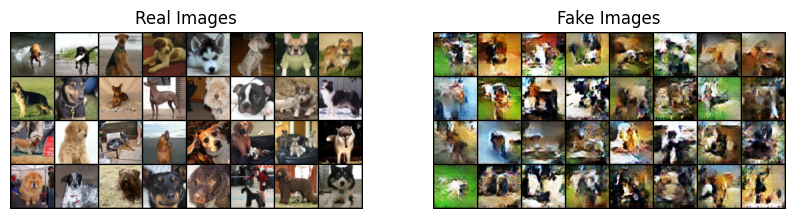

In [7]:
# Hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 2e-4
batch_size = 128
image_size = 64
channel_img = 3
z_dim = 100
num_epochs = 20
feature_d = 64
feature_g = 64

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        # transforms.Grayscale(num_output_channels=channel_img),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# dataset = datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/residentmario/segmented-bob-ross-images/versions/5, transform=transform)
# dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
dataset = datasets.ImageFolder(root="/content/Images", transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

gen = Generator(z_dim, channel_img, feature_g).to(device)
disc = Discriminator(channel_img, feature_d).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)

gen.train()
disc.train()

from IPython.display import clear_output

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise)

        # Discriminator Maximize log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = loss_disc_real + loss_disc_fake
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Generator Maximize log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 40 == 0:
            clear_output(wait=True)
            print(
                f"[Epoch {epoch+1}/{num_epochs}] [Batch {batch_idx}/{len(dataloader)}] | "
                f"Loss D: {loss_disc:.4f} | Loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = make_grid(real[:32], normalize=True)
                img_grid_fake = make_grid(fake[:32], normalize=True)

                # Display the image grids
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(np.transpose(img_grid_real.cpu(), (1, 2, 0)))
                plt.title("Real Images")
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.imshow(np.transpose(img_grid_fake.cpu(), (1, 2, 0)))
                plt.title("Fake Images")
                plt.axis("off")
                plt.show()

### Testing

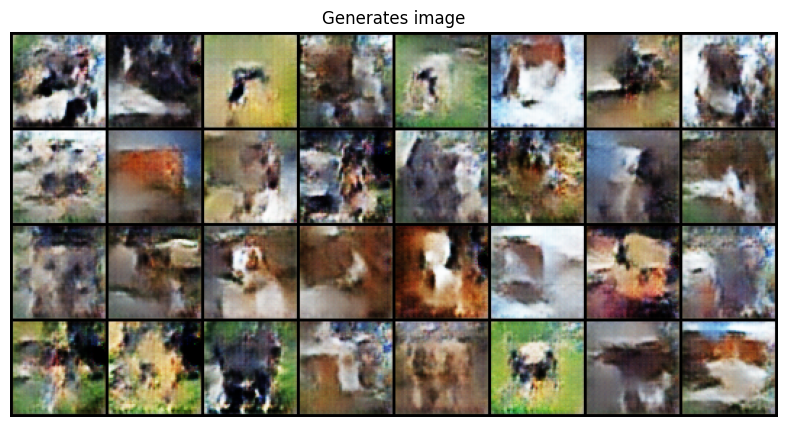

In [8]:
noise = torch.randn(32, z_dim, 1, 1).to(device)

with torch.no_grad():
    fake = gen(noise)
    img_grid_fake = make_grid(fake[:32], normalize=True)

    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(img_grid_fake.cpu(), (1, 2, 0)))
    plt.title("Generates image")
    plt.axis("off")
    plt.show()